In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = Path(r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling")

TRAIN_CUTTERS = ["c1", "c4", "c6"]   # labeled
TEST_CUTTERS  = ["c2", "c3", "c5"]   # unlabeled (for later inference)

print("Base exists:", BASE.exists())
print("Base path:", BASE)


In [ ]:
# List everything in BASE
items = list(BASE.iterdir())
for p in items:
    kind = "DIR " if p.is_dir() else "FILE"
    print(f"{kind:5} {p.name}")


In [ ]:
# Try to detect train/test folders automatically
train_dir = None
test_dir = None

for p in BASE.iterdir():
    if p.is_dir():
        name = p.name.lower()
        if "train" in name:
            train_dir = p
        elif "test" in name:
            test_dir = p

if train_dir is None:
    # Maybe cutters are directly under BASE
    print("No explicit Train folder found; assuming cutters are in BASE.")
    train_dir = BASE
else:
    print("Train directory:", train_dir)

if test_dir is None:
    print("No explicit Test folder found; assuming test cutters are in BASE or not needed yet.")
else:
    print("Test directory:", test_dir)


In [ ]:
print("Contents of train_dir:")
for p in sorted(train_dir.iterdir()):
    if p.is_dir():
        print("DIR ", p.name)
    else:
        print("FILE", p.name)


In [ ]:
def get_cutter_dir(cutter_id, base_dir):
    # try simple naming first
    candidates = []
    for p in base_dir.iterdir():
        if p.is_dir() and cutter_id.lower() in p.name.lower():
            candidates.append(p)
    return candidates

cutter = TRAIN_CUTTERS[0]  # "c1"
cutter_dirs = get_cutter_dir(cutter, train_dir)
print("Candidate directories for", cutter, ":")
for d in cutter_dirs:
    print("  ", d)

if len(cutter_dirs) == 0:
    print("No directories found matching", cutter)
else:
    c1_dir = cutter_dirs[0]
    print("\nUsing:", c1_dir)
    print("Contents of", c1_dir.name, ":")
    for p in sorted(c1_dir.iterdir()):
        kind = "DIR " if p.is_dir() else "FILE"
        print(f"{kind:5} {p.name}")


In [ ]:
from collections import Counter

ext_counter = Counter()
file_paths = []

for p in c1_dir.rglob("*"):
    if p.is_file():
        ext_counter[p.suffix.lower()] += 1
        file_paths.append(p)

print("File extensions and counts in", c1_dir.name)
for ext, cnt in ext_counter.items():
    print(f"{ext or '[no ext]'}: {cnt}")

# Show first 10 files as examples
print("\nFirst 10 files:")
for p in file_paths[:10]:
    print(p.relative_to(c1_dir))


In [ ]:
# pick the first csv-like file
csv_like_exts = {".csv", ".txt", ".dat"}
sample_file = None

for p in file_paths:
    if p.suffix.lower() in csv_like_exts:
        sample_file = p
        break

print("Sample file:", sample_file)

if sample_file is not None:
    # Try reading with default options
    try:
        df_sample = pd.read_csv(sample_file)
    except UnicodeDecodeError:
        df_sample = pd.read_csv(sample_file, encoding="latin1")
    except Exception as e:
        print("Default read_csv failed:", e)
        # try with a semicolon/space delimiter as backup
        try:
            df_sample = pd.read_csv(sample_file, sep=None, engine="python")
        except Exception as e2:
            print("Flexible read_csv failed too:", e2)
            df_sample = None

    if df_sample is not None:
        print("Shape:", df_sample.shape)
        print("Columns:", df_sample.columns.tolist())
        display(df_sample.head())


In [ ]:
from scipy.io import loadmat

sample_mat = None
for p in file_paths:
    if p.suffix.lower() == ".mat":
        sample_mat = p
        break

print("Sample mat file:", sample_mat)

if sample_mat is not None:
    mat_data = loadmat(sample_mat)
    print("Keys in MAT file:")
    for k in mat_data.keys():
        if not k.startswith("__"):
            print(" ", k, "->", type(mat_data[k]), "shape:", getattr(mat_data[k], "shape", None))


In [ ]:
label_keywords = ["wear", "vb", "VB", "label", "labels", "target"]

label_files = []
for p in file_paths:
    name = p.name.lower()
    if any(k.lower() in name for k in label_keywords):
        label_files.append(p)

print("Potential label files:")
for p in label_files:
    print(" ", p.relative_to(c1_dir))


In [ ]:
def load_wear(base_dir, cutter):
    wear_file = base_dir / cutter / f"{cutter}_wear.csv"
    df = pd.read_csv(wear_file)
    df['cutter'] = cutter
    return df

# Test
df_wear = load_wear(BASE, "c1")
df_wear.head()


In [ ]:
def load_cutter_dataset(base, cutter):
    cutter_folder = base / cutter / cutter  # <-- FIXED

    wear = pd.read_csv(base / cutter / f"{cutter}_wear.csv")

    feature_files = sorted(list(cutter_folder.glob("*.npz")))
    
    rows = []
    
    for file in feature_files:
        # extract sample id from filename
        cut_num = int(file.stem.split("_")[-1].split(".")[0])
        
        npz = np.load(file)
        
        # flatten features
        feat = []
        for key in npz.files:
            feat.extend(npz[key].flatten())

        # match wear row
        wear_row = wear[wear.cut == cut_num]
        
        if not wear_row.empty:
            rows.append({
                "cut": cut_num,
                "wear_flute1": wear_row.flute_1.values[0],
                "wear_flute2": wear_row.flute_2.values[0],
                "wear_flute3": wear_row.flute_3.values[0],
                "features": feat
            })

    return pd.DataFrame(rows)

# Test for c1
df_c1 = load_cutter_dataset(BASE, "c1")
df_c1.head()


In [ ]:
X = np.vstack(df_c1.features.values)
y = df_c1['wear_flute1'].values

print("Shape:", X.shape)


In [ ]:
def load_cutter_dataset(base, cutter):
    cutter_folder = base / cutter / cutter  # <-- FIXED

    wear = pd.read_csv(base / cutter / f"{cutter}_wear.csv")

    feature_files = sorted(list(cutter_folder.glob("*.npz")))
    
    rows = []
    
    for file in feature_files:
        # extract sample id from filename
        cut_num = int(file.stem.split("_")[-1].split(".")[0])
        
        npz = np.load(file)
        
        # flatten features
        feat = []
        for key in npz.files:
            feat.extend(npz[key].flatten())

        # match wear row
        wear_row = wear[wear.cut == cut_num]
        
        if not wear_row.empty:
            rows.append({
                "cut": cut_num,
                "wear_flute1": wear_row.flute_1.values[0],
                "wear_flute2": wear_row.flute_2.values[0],
                "wear_flute3": wear_row.flute_3.values[0],
                "features": feat
            })

    return pd.DataFrame(rows)

# Test for c1
df_c1 = load_cutter_dataset(BASE, "c1")
df_c1.head()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Using flute_1 wear as the target for now
y = df_c1['wear_flute1'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))

print(f"R² Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"RMSE     : {rmse:.4f}")


In [ ]:
df_c1.columns


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_c1["cut"], df_c1["wear_flute1"], marker='o')
plt.title("Tool Wear Progression Over Cuts (C1 - Flute 1)")
plt.xlabel("Cut Number")
plt.ylabel("Wear (Flute 1)")
plt.grid(True)
plt.show()


In [ ]:
FAILURE_THRESHOLD = 80.0  # you can adjust later

df_c1["RUL"] = FAILURE_THRESHOLD - df_c1["wear_flute1"]
df_c1["RUL"] = df_c1["RUL"].clip(lower=0)

df_c1[["cut", "wear_flute1", "RUL"]].head()


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_c1["cut"], df_c1["RUL"], marker='o')
plt.title("Remaining Useful Life Curve (C1 - Flute 1)")
plt.xlabel("Cut Number")
plt.ylabel("RUL (Remaining Wear Margin)")
plt.grid(True)
plt.show()


In [ ]:
cutters = ["c1", "c4", "c6"]  # labeled group


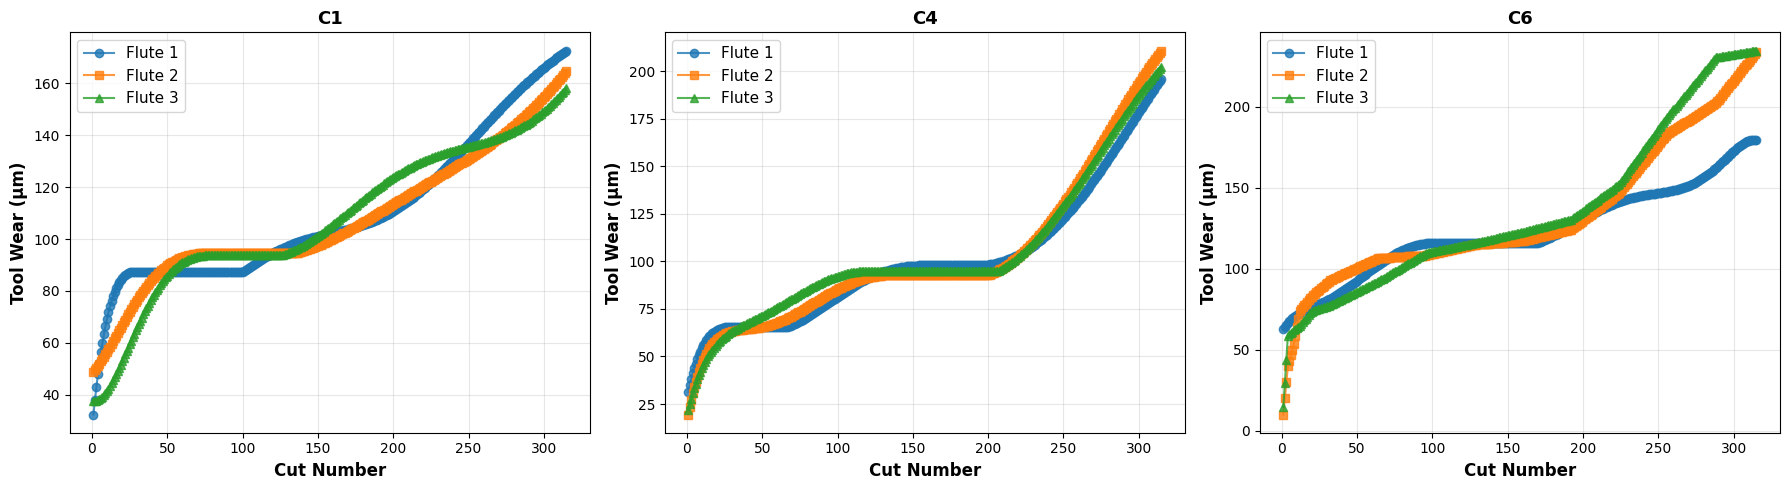

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path(r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling")

cutters_to_plot = ["c1", "c4", "c6"]  # modify if needed

fig, axs = plt.subplots(1, len(cutters_to_plot), figsize=(18, 5))

for idx, cutter in enumerate(cutters_to_plot):
    wear_file = BASE / cutter / f"{cutter}_wear.csv"
    df = pd.read_csv(wear_file)

    cuttimes = df['cut']
    f1 = df['flute_1']
    f2 = df['flute_2']
    f3 = df['flute_3']

    ax = axs[idx]
    ax.plot(cuttimes, f1, label='Flute 1', marker='o', alpha=0.8)
    ax.plot(cuttimes, f2, label='Flute 2', marker='s', alpha=0.8)
    ax.plot(cuttimes, f3, label='Flute 3', marker='^', alpha=0.8)

    ax.set_xlabel('Cut Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tool Wear (µm)', fontsize=12, fontweight='bold')
    ax.set_title(cutter.upper(), fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


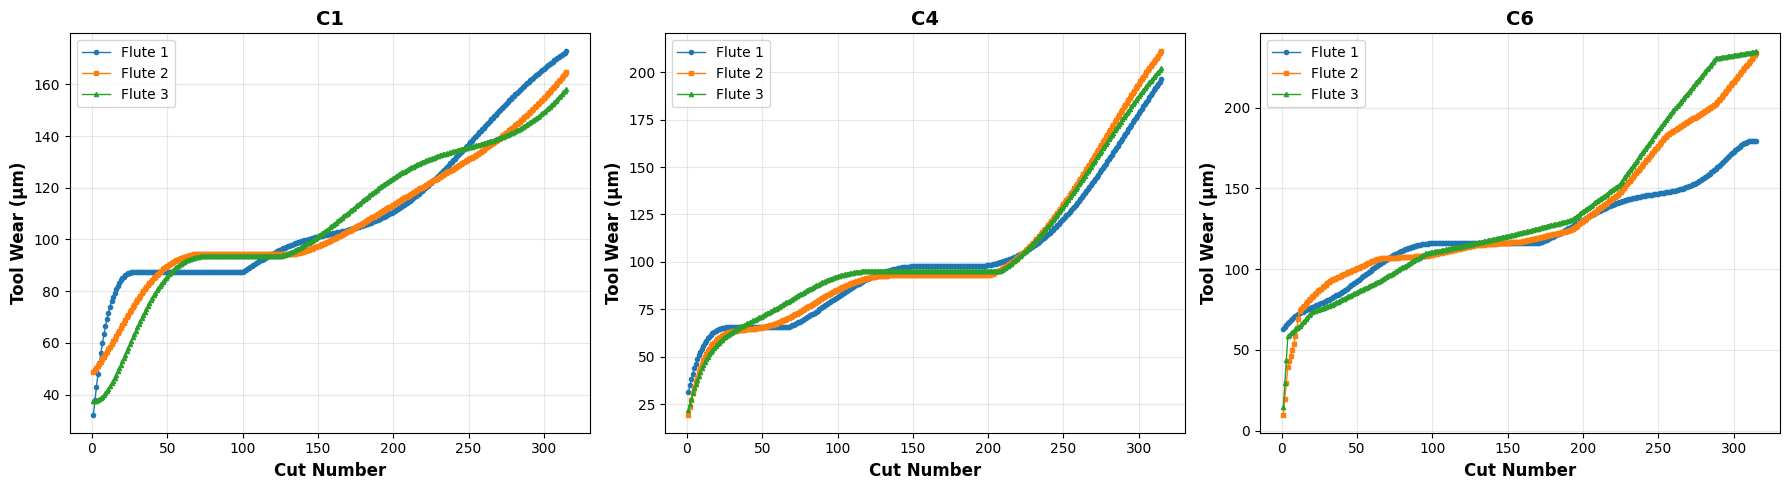

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path(r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling")

cutters_to_plot = ["c1", "c4", "c6"]

fig, axs = plt.subplots(1, len(cutters_to_plot), figsize=(18, 5))

for idx, cutter in enumerate(cutters_to_plot):
    wear_file = BASE / cutter / f"{cutter}_wear.csv"
    df = pd.read_csv(wear_file)

    cuttimes = df['cut']

    ax = axs[idx]
    ax.plot(cuttimes, df['flute_1'], label='Flute 1', marker='o', markersize=3, linewidth=1, alpha=1)
    ax.plot(cuttimes, df['flute_2'], label='Flute 2', marker='s', markersize=3, linewidth=1, alpha=1)
    ax.plot(cuttimes, df['flute_3'], label='Flute 3', marker='^', markersize=3, linewidth=1, alpha=1)

    ax.set_xlabel('Cut Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tool Wear (µm)', fontsize=12, fontweight='bold')
    ax.set_title(cutter.upper(), fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


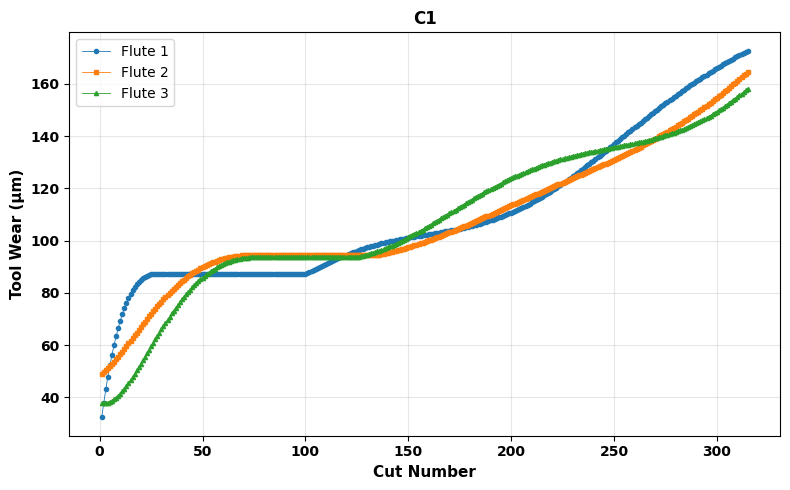

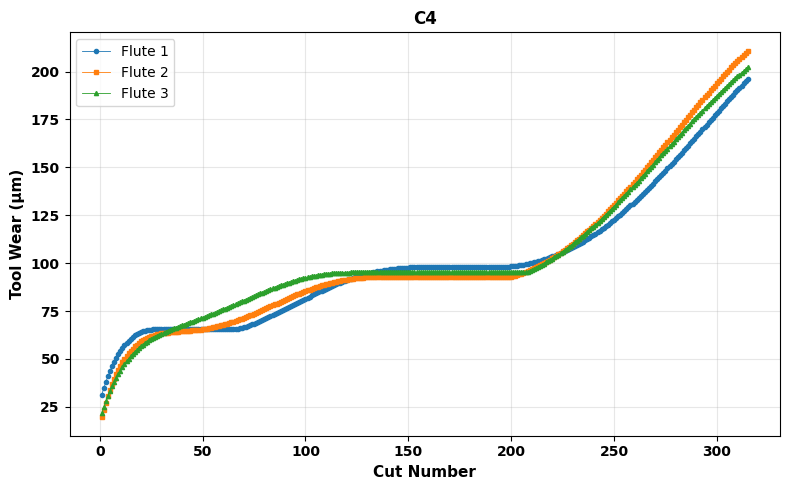

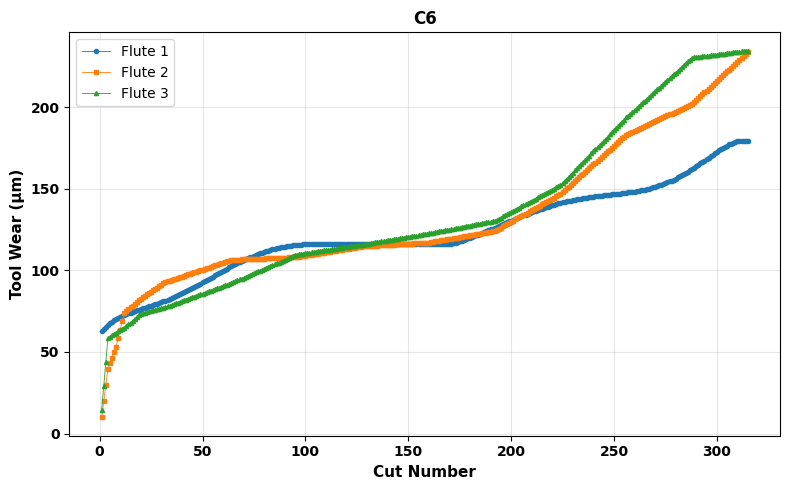


✔ Saved with bold tick values: E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling\plots


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Remove grey seaborn-style background
plt.style.use("default")

BASE = Path(r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling")
SAVE_DIR = BASE / "plots"
SAVE_DIR.mkdir(exist_ok=True)

cutters_to_plot = ["c1", "c4", "c6"]

for cutter in cutters_to_plot:
    wear_file = BASE / cutter / f"{cutter}_wear.csv"
    df = pd.read_csv(wear_file)

    cuttimes = df['cut']

    plt.figure(figsize=(8, 5))

    plt.plot(cuttimes, df['flute_1'], label='Flute 1', marker='o', markersize=3, linewidth=0.6)
    plt.plot(cuttimes, df['flute_2'], label='Flute 2', marker='s', markersize=3, linewidth=0.6)
    plt.plot(cuttimes, df['flute_3'], label='Flute 3', marker='^', markersize=3, linewidth=0.6)

    # Labels
    plt.xlabel('Cut Number', fontsize=11, fontweight='bold')
    plt.ylabel('Tool Wear (µm)', fontsize=11, fontweight='bold')
    plt.title(cutter.upper(), fontsize=12, fontweight='bold')

    # Make tick values bold
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')

    # Grid + Legend
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    plt.tight_layout()

    # Save (transparent optional)
    save_path = SAVE_DIR / f"{cutter}_wear_plot.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()

print(f"\n✔ Saved with bold tick values: {SAVE_DIR}")
